### Section Notes

In this section, we will be testing our baseline models and evaulate their performance on the dataset after feature engineering

### Setting up

In [11]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import pandas as pd
import numpy as np
import optuna
import sklearn 
import sklearn.datasets
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Helper method
# You may consider changeing the colour scheme in practice

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Loading Data and Train-Test split

Please note that we will be sticking to **seed 42** throughout all train-test splits

#### Loading Data

In [14]:
df_train = pd.read_csv('/content/drive/MyDrive/ST4248 Project/dataset/train_normalised.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ST4248 Project/dataset/test_normalised.csv')

# Guan Yee Directory
#df_train = pd.read_csv('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Project/dataset/train_normalised_new.csv')
#df_test = pd.read_csv('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Project/dataset/test_normalised_new.csv')

In [ ]:
X_train = df_train.drop("is_canceled", axis = 1)
y_train = df_train["is_canceled"]

X_test = df_test.drop("is_canceled", axis = 1)
y_test = df_test["is_canceled"]

In [ ]:
train_dataset = lgb.Dataset(
    data = X_train,
    label = y_train,
    categorical_feature=[0, 2, 3, 5, 6, 7, 10, 11, 13, 15, 21, 22], 
    free_raw_data=False
)

test_dataset = lgb.Dataset(
    data = X_test,
    label = y_test,
    categorical_feature=[0, 2, 3, 5, 6, 7, 10, 11, 13, 15, 21, 22],
    free_raw_data=False
)

In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 81957 entries, 0 to 81956
Series name: is_canceled
Non-Null Count  Dtype
--------------  -----
81957 non-null  int64
dtypes: int64(1)
memory usage: 640.4 KB


### Bayesian Tuner

**没事别乱跑，一跑一小时**

In [ ]:
def objective(trial):
  params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 20, 2000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 200, 1000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 30, step=1),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 30, step=1),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        "subsample": trial.suggest_float(
            "subsample", 0.2, 0.9, step=0.1
        ),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.2, 0.9, step=0.1
        ),
  }

  model = LGBMClassifier(objective="binary", **params, random_state = 42)

  strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)
    
  score = cross_val_score(model, X_train, y_train, cv = strat_k_fold).mean()
  return score

In [ ]:
study = optuna.create_study(direction = "maximize")

study.optimize(objective, n_trials = 100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}= {}, ".format(key, value))

[I 2023-03-25 08:00:40,146] A new study created in memory with name: no-name-e844a159-3c30-4d7c-a137-54cea8035ab2
[I 2023-03-25 08:00:50,657] Trial 0 finished with value: 0.8186243684301152 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 419, 'learning_rate': 0.47554849963446527, 'num_leaves': 140, 'max_depth': 12, 'min_child_samples': 1000, 'max_bin': 292, 'reg_alpha': 7, 'reg_lambda': 29, 'min_split_gain': 14.678609289256155, 'subsample': 0.4, 'colsample_bytree': 0.4}. Best is trial 0 with value: 0.8186243684301152.
[I 2023-03-25 08:01:11,923] Trial 1 finished with value: 0.8187829861100255 and parameters: {'boosting_type': 'dart', 'n_estimators': 185, 'learning_rate': 0.3827988366295813, 'num_leaves': 1440, 'max_depth': 8, 'min_child_samples': 1000, 'max_bin': 285, 'reg_alpha': 22, 'reg_lambda': 5, 'min_split_gain': 12.142114135245942, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001}. Best is trial 1 with value: 0.8187829861100255.
[I 2023-03-25 08

Best Score:  0.8440523335024259
Best Params: 
  boosting_type= gbdt, 
  n_estimators= 303, 
  learning_rate= 0.19095216992168662, 
  num_leaves= 1520, 
  max_depth= 8, 
  min_child_samples= 400, 
  max_bin= 232, 
  reg_alpha= 2, 
  reg_lambda= 11, 
  min_split_gain= 0.014631453059384972, 
  subsample= 0.5, 
  colsample_bytree= 0.30000000000000004, 


### Testing the new LightGBM


There is serious overfitting problem. According to lightGBM mannual, to fix overfitting: 

Use small max_bin
Use small num_leaves
Use min_data_in_leaf and min_sum_hessian_in_leaf
Use bagging by set bagging_fraction and bagging_freq
Use feature sub-sampling by set feature_fraction
Use bigger training data
Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
Try max_depth to avoid growing deep tree

here: 

num_leave = 1140 and max_bin = 230 are way too large, consider min_gain_to_split. 

--------LGBM Tuned--------


/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Correctly classified instances: 29715
Accuracy Score is 0.84598
Recall Score is 0.72863
Precision Score is 0.84228
F1 Score is 0.78134
       0     1
0  20049  1810
1   3600  9666
[[20049  1810]
 [ 3600  9666]]


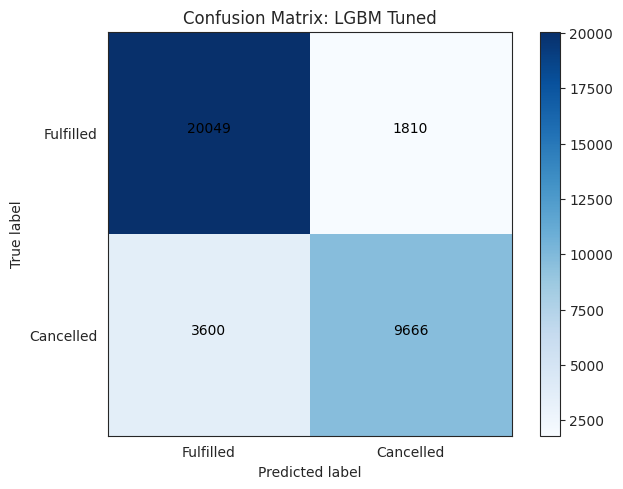

In [16]:
print("--------LGBM Tuned--------")

model = LGBMClassifier(
    random_state = 42,
    boosting_type= "gbdt", 
    n_estimators= 303, 
    learning_rate= 0.19095216992168662, 
    num_leaves= 1520, 
    max_depth= 8, 
    min_child_samples= 400,
    max_bin= 232, 
    reg_alpha= 2, 
    reg_lambda= 11, 
    min_split_gain= 0.014631453059384972, 
    subsample= 0.5, 
    colsample_bytree= 0.30000000000000004)
model.fit(X_train, y_train,
          categorical_feature=[0, 2, 3, 5, 6, 7, 10, 11, 13, 15, 21, 22])


y_predict = model.predict(X_test)

print(f'Correctly classified instances: {sum(y_predict == y_test)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['Fulfilled','Cancelled']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: LGBM Tuned')

In [10]:
print("--------LGBM Tuned--------")

params = {
    "random_state" : 42,
    "n_estimators" : 500}

model = lgb.train(params, train_dataset)


y_predict_prob = model.predict(X_test)

y_predict = np.round(y_predict_prob)

print(f'Correctly classified instances: {sum(y_predict == y_test)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['Fulfilled','Cancelled']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: LGBM Tuned')

--------LGBM Tuned--------


NameError: ignored

Unbalanced tree check

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the tree details
tree_df = pd.DataFrame(model.booster_.trees_to_dataframe())
tree_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23975 entries, 0 to 23974
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tree_index         23975 non-null  int64  
 1   node_depth         23975 non-null  int64  
 2   node_index         23975 non-null  object 
 3   left_child         11836 non-null  object 
 4   right_child        11836 non-null  object 
 5   parent_index       23672 non-null  object 
 6   split_feature      11836 non-null  object 
 7   split_gain         11836 non-null  float64
 8   threshold          11836 non-null  object 
 9   decision_type      11836 non-null  object 
 10  missing_direction  11836 non-null  object 
 11  missing_type       11836 non-null  object 
 12  value              23975 non-null  float64
 13  weight             23975 non-null  float64
 14  count              23975 non-null  int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 2.7+ MB


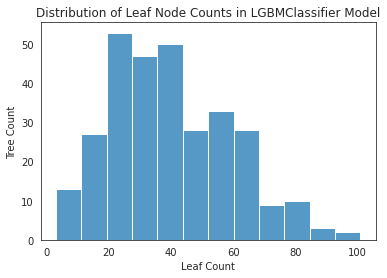

In [ ]:
# Get tree details DataFrame
tree_df = pd.DataFrame(model.booster_.trees_to_dataframe())

# Filter out non-leaf nodes
leaf_df = tree_df[tree_df['left_child'].isnull() & tree_df['right_child'].isnull()]

# Group by tree_index and count the number of leaf nodes in each tree
leaf_count = leaf_df.groupby('tree_index').count()['count']

# Plot the leaf count distribution
sns.histplot(leaf_count, kde=False)
plt.xlabel('Leaf Count')
plt.ylabel('Tree Count')
plt.title('Distribution of Leaf Node Counts in LGBMClassifier Model')
plt.show()

In [ ]:
# Set the dpi to 1200 for high resolution
plt.savefig("/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Project/Final Presentation/leaf_node_count.png", dpi=1200)

<Figure size 432x288 with 0 Axes>